In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [ ]:
import pandas as pd
from pymongo import MongoClient

# Menghubungkan ke server MongoDB (secara lokal)
client = MongoClient('localhost', 27017)
db = client['google_play_store_data']
collection = db['04. label_data_bibit'] 

# Mengambil semua dokumen dalam koleksi
cursor = collection.find()

# Mengonversi data ke dalam bentuk DataFrame
df_bibit = pd.DataFrame(list(cursor))

# Menutup koneksi dengan server MongoDB
client.close()

df_bibit


In [26]:
# Pisahkan data menjadi data train dan test
train_data = df_bibit[df_bibit["label"].notnull()]  
test_data = df_bibit[df_bibit["label"].isnull()] 


In [27]:
train_data.head()

,_id,at,data_clean,label
0,663862c1dd520c9ba22efdc2,2024-05-05T12:11:55.000Z,verifikasi jelek,-1.0
1,663862c1dd520c9ba22efdc3,2024-05-05T07:32:30.000Z,gagal tanda tangan coba ulang foto ktp foto ktp,-1.0
2,663862c1dd520c9ba22efdc4,2024-05-05T06:58:43.000Z,selesai verifikasi kecewa aplikasi burik,-1.0
4,663862c1dd520c9ba22efdc6,2024-05-04T05:10:50.000Z,aplikasi ganguan sisa jual saham cocok barusan...,-1.0
7,663862c1dd520c9ba22efdc9,2024-05-03T15:17:09.000Z,astaga main aplikasi investasi cocok topup mas...,-1.0
...,...,...,...,...
3066,663862d9dd520c9ba22f0a60,2022-04-16T20:05:30.000Z,ajaib mahasiswa investasi recomend gampang pah...,1.0
3067,663862d9dd520c9ba22f0a61,2023-01-31T18:48:57.000Z,salah aplikasi investasi bagus mula tampilanya...,1.0
3068,663862d9dd520c9ba22f0a62,2020-10-03T16:38:30.000Z,aplikasi sederhana mudah recomended mula info ...,1.0
3264,663862dcdd520c9ba22f0b33,2023-11-23T14:48:36.000Z,candle stik bagus versi,1.0


In [28]:
test_data.head()

,_id,at,data_clean,label
3,663862c1dd520c9ba22efdc5,2024-05-04T16:24:09.000Z,cocok jual saham,NaN
5,663862c1dd520c9ba22efdc7,2024-05-03T23:03:50.000Z,tolong baik saham hilang kembali dana,NaN
6,663862c1dd520c9ba22efdc8,2024-05-03T15:55:27.000Z,ruang email adu jam kerja konfirmasi deposit r...,NaN
8,663862c1dd520c9ba22efdca,2024-05-03T15:14:10.000Z,males mengunakan aplikasi buka login lelah,NaN
10,663862c1dd520c9ba22efdcd,2024-05-01T14:43:10.000Z,lengkap data ambil foto ktp pencet tanda centa...,NaN
...,...,...,...,...
8627,663a4aee22061f845eb78b6c,2021-12-02T17:27:44.000Z,maf tarik dana saldo rdn cba kali salah,NaN
8628,663a4aee22061f845eb78b6d,2021-12-02T16:09:06.000Z,bantu nyaman,NaN
8629,663a4aee22061f845eb78b6e,2021-12-02T15:21:33.000Z,eroro kakak,NaN
8630,663a4aee22061f845eb78b70,2021-12-02T14:37:57.000Z,bantu aplikasi ajaibtpi login akun,NaN


In [29]:
# Preprocess untuk training data
X_train = train_data["data_clean"]
y_train = train_data["label"]

# Preprocess untuk testing data
X_test = test_data["data_clean"]


In [30]:
# Tokenize and pad sequences for training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences_train)

# Tokenize and pad sequences for testing data
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])


In [31]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [32]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=X_train.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\miase\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
# Train the model
model.fit(X_train, to_categorical(y_train), validation_data=(X_val, to_categorical(y_val)), epochs=10, batch_size=32)


Epoch 1/10


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6583 - loss: 0.6621 - val_accuracy: 0.9100 - val_loss: 0.4260
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9091 - loss: 0.3002 - val_accuracy: 0.9550 - val_loss: 0.1504
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9681 - loss: 0.0814 - val_accuracy: 0.9750 - val_loss: 0.0512
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9900 - val_loss: 0.0321
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9900 - val_loss: 0.0287
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9900 - val_loss: 0.0240
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9850 - val_loss: 0.0217
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 9.9117e-04 - val_accuracy: 0.9850 - val_loss

In [34]:
# Evaluate the model
y_pred_probs = model.predict(X_val)
y_pred = label_encoder.inverse_transform(y_pred_probs.argmax(axis=1))
y_true = label_encoder.inverse_transform(y_val)

# Print classification report
classification_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99       100
         1.0       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [35]:
# Predict the labels for testing data
predicted_labels = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(predicted_labels.argmax(axis=1))

# Assign the predicted labels to the testing data
test_data["label"] = predicted_labels

# Save the predicted labels to a new Excel file
test_data.to_excel("hasil_testing1.xlsx", index=False)


  1/239 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\miase\AppData\Local\Temp\ipykernel_14424\714833348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["label"] = predicted_labels


In [36]:
# Preprocess the data
text = "mudah cepat"

# Tokenize and pad the sequence
sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=X_train.shape[1])

# Predict the label
predicted_label = model.predict(padded_sequence)
predicted_label = label_encoder.inverse_transform(predicted_label.argmax(axis=1))

# Print the predicted label
print("Predicted Label:", predicted_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: 1.0


In [37]:
# Load the data for word cloud
wordcloud_data = pd.read_excel("hasil_testing1.xlsx")

# Filter the data for label with value "1"
label_data = wordcloud_data[wordcloud_data['label'] == 'positif']

# Combine the labels into a single string
labels_text = ' '.join(label_data['data_clean'])

# Split the text into individual words
words = labels_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Generate the word cloud with unique words
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Sentimen Positif')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

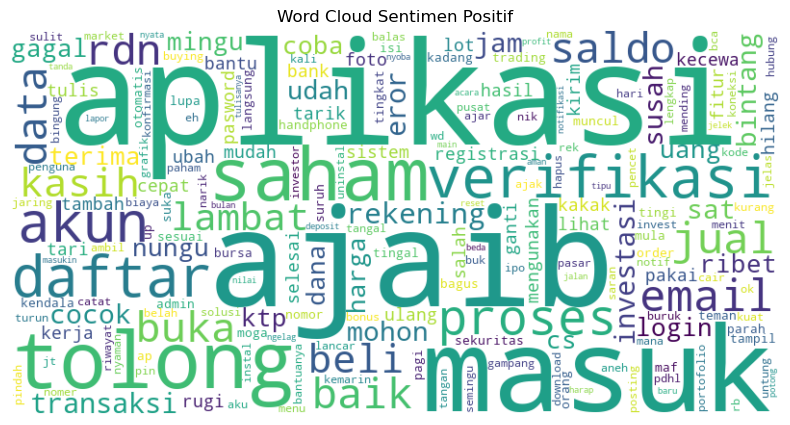

In [ ]:
# Load the data for word cloud
wordcloud_data = pd.read_excel("hasil_testing1.xlsx")

# Filter the data for label with value "1"
label_data = wordcloud_data[wordcloud_data['label'] == 'negatif']

# Combine the labels into a single string
labels_text = ' '.join(label_data['data_clean'])

# Split the text into individual words
words = labels_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Generate the word cloud with unique words
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Sentimen Positif')
plt.show()

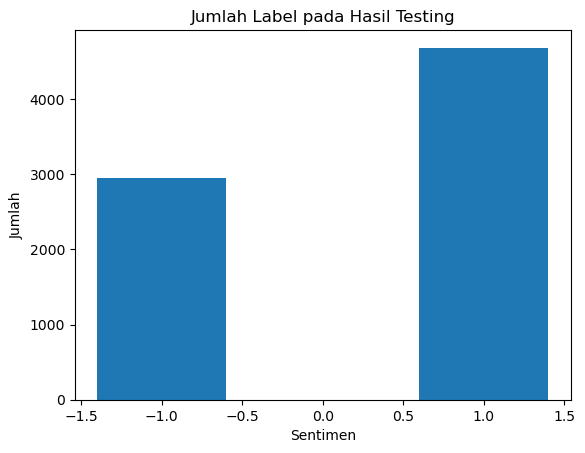

   Sentimen  Jumlah
0         1    4684
1        -1    2948


In [38]:
# Load the modified testing data
modified_data = pd.read_excel("hasil_testing1.xlsx")

# Count the occurrences of each label
label_counts = modified_data["label"].value_counts()

# Extract the label values and their corresponding counts
labels = label_counts.index.tolist()
counts = label_counts.values.tolist()

# Map the label values to their corresponding sentiment
labels = [label for label in labels]

# Plot the bar chart
plt.bar(labels, counts)
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.title("Jumlah Label pada Hasil Testing")
plt.show()

chart_data = pd.DataFrame({"Sentimen": labels, "Jumlah": counts})
print(chart_data)

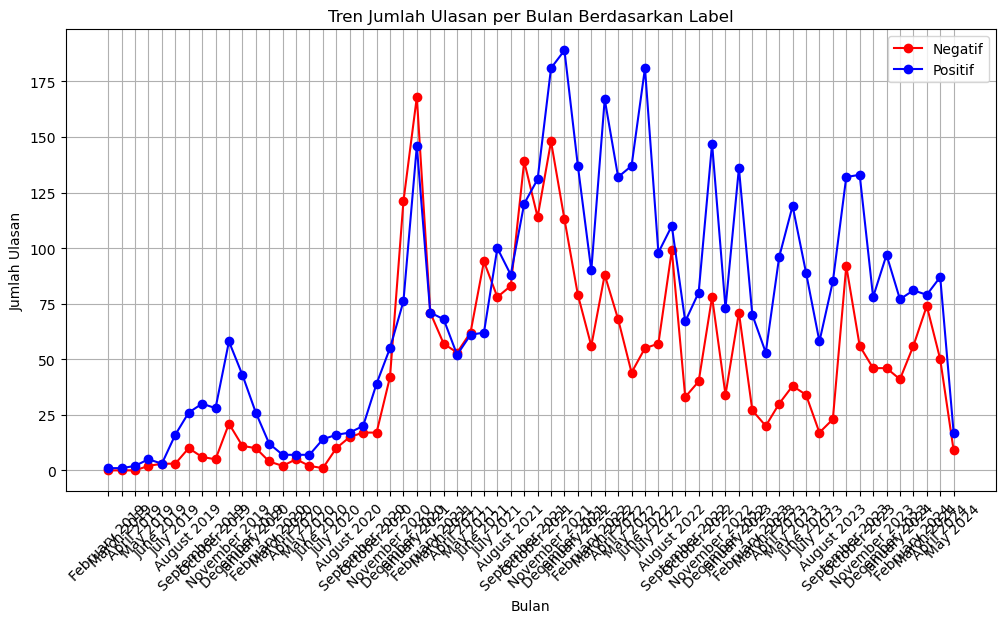

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Memuat data dari Excel file
df = pd.read_excel("hasil_testing1.xlsx")

# Mengubah kolom "review_date" menjadi tipe data datetime
df['at'] = pd.to_datetime(df['at'])

# Mengatur kolom "review_date" sebagai indeks dataframe
df.set_index('at', inplace=True)

# Mengganti nilai label menjadi "Positif", "Netral", dan "Negatif"
label_mapping = {1: 'Positif', -1: 'Negatif'}
df['label'] = df['label'].map(label_mapping)

# Menghitung jumlah ulasan per bulan berdasarkan label
monthly_reviews = df.groupby([pd.Grouper(freq='M'), 'label']).size().unstack().fillna(0)

# Membuat line chart untuk tren jumlah ulasan per bulan berdasarkan label
plt.figure(figsize=(12, 6))
labels = ['Negatif','Positif']
colors = ['red', 'blue']
x_values = range(len(monthly_reviews.index))
for i, (label, color) in enumerate(zip(labels, colors)):  # Menambahkan variabel i
    plt.plot(x_values, monthly_reviews[label], marker='o', label=label, color=color)  # Menggunakan x_values

plt.title('Tren Jumlah Ulasan per Bulan Berdasarkan Label')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Ulasan')

# Mengatur sumbu x dengan rentang bulan dan tahun yang sesuai
plt.xticks(x_values, [d.strftime('%B %Y') for d in monthly_reviews.index], rotation=45)  # Menggunakan x_values dan monthly_reviews.index

plt.legend()
plt.grid(True)
plt.show()